Vizulizations for predictions are bad because of scaling, but while rmse scales, the r-sqaured value doesn't 

stock returns are in percentage change not raw value, harder to predict but more useful.


In [372]:
import requests
import json
import pandas as pd
import numpy as np
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
np.random.seed(0)
from pandas import read_csv
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns

import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from pandas import read_csv
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from pandas import concat

from math import sqrt
from numpy import concatenate

from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [1028]:
teslaDataset = pd.read_csv('tesla_dataset_2.csv') 

there might be something we can do with scaling to improve linear regression, but it also might just be a bust. 

In [1039]:
#trying a linear regression. data may still be in a terrible form 
tesla_copy = teslaDataset.copy()
tesla_c = tesla_copy#tesla_copy[['stockPrice', 'sp500']]
train = tesla_c .iloc[:220,:]
test = tesla_c .iloc[220:,:]

In [1040]:
X_train = train.drop(['stockPrice'], axis = 1)
y_train = train[["stockPrice"]]

X_test = test.drop(['stockPrice'], axis = 1)
y_test = test[["stockPrice"]]

In [1041]:
reg = LinearRegression().fit(X_train, y_train)
train = reg.score(X_train, y_train)
test = reg.score(X_test, y_test)#this is R squared

In [1042]:
print("train R2:", train)
print("test R2:", test)
#fill na to zero probs to blame. Not enough data???


train R2: 0.2835216067338854
test R2: 0.4151362075103794


In [1043]:
reg.coef_

array([[-2.60613004e-06, -1.43882448e-01,  7.01762243e+00,
         5.01882578e-06, -1.33864294e-04,  1.79515412e-01,
         1.74383171e+00]])

In [1044]:
y_test = y_test.reset_index(drop=True)

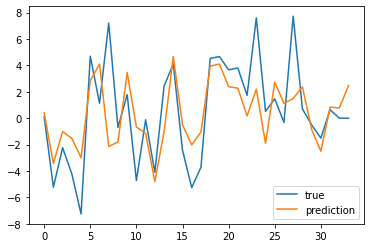

In [1045]:
pred = reg.predict(X_test)
pyplot.plot(y_test, label='true')
pyplot.plot( pred, label='prediction')
pyplot.legend()
pyplot.show()

In [1046]:
sqrt(mean_squared_error(y_test, pred))

2.8734103532807964

In [1047]:
#quick attempt at lstm

In [1048]:
tesla_copy

,stockPrice,change_buy,price_buy,count_buy,change_sale,price_sale,count_sale,sp500
0,0.082450,0.0,0.00,0.0,0.0,0.000,0.0,-0.097401
1,-3.030996,0.0,0.00,0.0,0.0,0.000,0.0,0.147414
2,1.894051,0.0,0.00,0.0,0.0,0.000,0.0,0.421175
3,-0.996453,0.0,0.00,0.0,0.0,0.000,0.0,0.769028
4,3.620009,10000.0,55.32,1.0,-10000.0,10425.646,15.0,-0.019620
...,...,...,...,...,...,...,...,...
249,-0.508758,0.0,0.00,0.0,0.0,0.000,0.0,-0.631359
250,-1.509494,0.0,0.00,0.0,0.0,0.000,0.0,-1.577600
251,0.646566,0.0,0.00,0.0,0.0,0.000,0.0,0.340448
252,0.000000,12000.0,74.17,1.0,-12000.0,16905.681,25.0,1.175564


In [971]:
#this creates the sequence
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            cols.append(df.shift(-i))
            if i == 0:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
        agg = concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [1049]:
tesla_values = tesla_copy.values

In [1050]:
tesla_values = tesla_values.astype('float64')
# normalize features

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(tesla_values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed_2 = reframed.drop(columns=['var8(t-1)', 'var8(t)'])

#print(reframed_2.head())

In [1051]:
values = reframed.values

In [1052]:
values.shape


(253, 16)

In [1053]:
values = reframed.values
n_train_hours = 220
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(220, 1, 15) (220,) (33, 1, 15) (33,)


Epoch 1/60
15/15 - 10s - loss: 0.0996 - val_loss: 0.2714 - 10s/epoch - 665ms/step
Epoch 2/60
15/15 - 0s - loss: 0.0946 - val_loss: 0.2666 - 157ms/epoch - 10ms/step
Epoch 3/60
15/15 - 0s - loss: 0.0934 - val_loss: 0.2662 - 146ms/epoch - 10ms/step
Epoch 4/60
15/15 - 0s - loss: 0.0932 - val_loss: 0.2666 - 125ms/epoch - 8ms/step
Epoch 5/60
15/15 - 0s - loss: 0.0933 - val_loss: 0.2668 - 121ms/epoch - 8ms/step
Epoch 6/60
15/15 - 0s - loss: 0.0933 - val_loss: 0.2667 - 120ms/epoch - 8ms/step
Epoch 7/60
15/15 - 0s - loss: 0.0933 - val_loss: 0.2667 - 113ms/epoch - 8ms/step
Epoch 8/60
15/15 - 0s - loss: 0.0933 - val_loss: 0.2666 - 131ms/epoch - 9ms/step
Epoch 9/60
15/15 - 0s - loss: 0.0933 - val_loss: 0.2666 - 117ms/epoch - 8ms/step
Epoch 10/60
15/15 - 0s - loss: 0.0932 - val_loss: 0.2663 - 121ms/epoch - 8ms/step
Epoch 11/60
15/15 - 0s - loss: 0.0930 - val_loss: 0.2646 - 127ms/epoch - 8ms/step
Epoch 12/60
15/15 - 0s - loss: 0.0899 - val_loss: 0.2416 - 124ms/epoch - 8ms/step
Epoch 13/60
15/15 - 0s

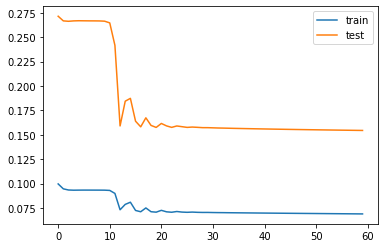

In [1054]:

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))

model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=60, batch_size=15, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [1055]:
#pyplot.plot(test_y, label='true')
#pyplot.plot( y_pred, label='prediction')
#pyplot.legend()
#pyplot.show()

In [1056]:
#figure out hwo to do this part and vizualize teh predictions in thri actual format
# make a prediction
yhat = model.predict(test_X)#y_pred #just cant do this line twice?
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))


In [1057]:
#train 
y_train_pred = model.predict(train_X)#y_pred #just cant do this line twice?
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
r2_score(train_y, y_train_pred )

0.28039735108187813

In [1058]:
#test
r2_score(test_y, yhat)


0.4187377066911685

In [1059]:
#rmse
sqrt(mean_squared_error(test_y, yhat))

0.3929493451482875

In [1060]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:8]), axis=1)
#inv_yhat = scaler.inverse_transform(inv_yhat)
#inv_yhat = inv_yhat[:,0]


In [1061]:
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [1062]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:8]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


In [1063]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 4.996


In [1064]:
r2_score(inv_y,inv_yhat)

0.4187377066911684

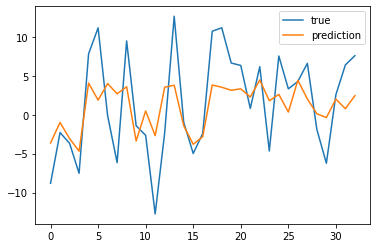

In [1065]:
pyplot.plot(inv_y, label='true')
pyplot.plot(inv_yhat, label='prediction')
pyplot.legend()
pyplot.show()

In [778]:
#moving/copying univariate attempt

In [1066]:
#single variable??? I think using just teh stock has very poor results, geunuenly. 
#try predicting based on adding in each variable to the dataset, stepwise
#use this for model building instead of previously thoughto of linear regression piece.
#try steping through and adding in only the best values??

#do not run for multi variate. might be an error beyond values here 
tesla_values = tesla_copy[['stockPrice', 'sp500' ]].values # , 'sp500' ,'count_buy', 'count_sale'

tesla_values = tesla_values.astype('float32')
# normalize features
#tesla_values = tesla_values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(tesla_values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict

print(reframed.head())

   var1(t-1)  var2(t-1)   var1(t)   var2(t)
1   0.009663   0.047711 -0.235210  0.136199
2  -0.235210   0.136199  0.152145  0.235150
3   0.152145   0.235150 -0.075193  0.360882
4  -0.075193   0.360882  0.287892  0.075825
5   0.287892   0.075825  0.651370  0.201803


In [1108]:
values = reframed.values
n_train_hours = 220
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(220, 1, 3) (220,) (33, 1, 3) (33,)


Epoch 1/60
15/15 - 7s - loss: 0.0996 - val_loss: 0.2713 - 7s/epoch - 436ms/step
Epoch 2/60
15/15 - 0s - loss: 0.0945 - val_loss: 0.2662 - 105ms/epoch - 7ms/step
Epoch 3/60
15/15 - 0s - loss: 0.0932 - val_loss: 0.2650 - 93ms/epoch - 6ms/step
Epoch 4/60
15/15 - 0s - loss: 0.0926 - val_loss: 0.2637 - 99ms/epoch - 7ms/step
Epoch 5/60
15/15 - 0s - loss: 0.0916 - val_loss: 0.2584 - 91ms/epoch - 6ms/step
Epoch 6/60
15/15 - 0s - loss: 0.0880 - val_loss: 0.2389 - 83ms/epoch - 6ms/step
Epoch 7/60
15/15 - 0s - loss: 0.0786 - val_loss: 0.1957 - 85ms/epoch - 6ms/step
Epoch 8/60
15/15 - 0s - loss: 0.0762 - val_loss: 0.1781 - 89ms/epoch - 6ms/step
Epoch 9/60
15/15 - 0s - loss: 0.0768 - val_loss: 0.1810 - 90ms/epoch - 6ms/step
Epoch 10/60
15/15 - 0s - loss: 0.0752 - val_loss: 0.1800 - 94ms/epoch - 6ms/step
Epoch 11/60
15/15 - 0s - loss: 0.0752 - val_loss: 0.1768 - 94ms/epoch - 6ms/step
Epoch 12/60
15/15 - 0s - loss: 0.0752 - val_loss: 0.1762 - 93ms/epoch - 6ms/step
Epoch 13/60
15/15 - 0s - loss: 0.075

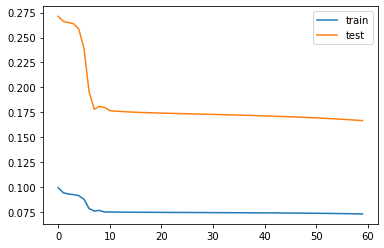

In [1109]:

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=60, batch_size=15, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [1110]:
yhat = model.predict(test_X)#y_pred #just cant do this line twice?
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))


In [1111]:
#train 
y_train_pred = model.predict(train_X)#y_pred #just cant do this line twice?
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
r2_score(train_y, y_train_pred )

0.21909007754787824

In [1112]:
#test
r2_score(test_y, yhat)


0.37220798131734323

In [1113]:
inv_yhat.shape

(33, 3)

In [1116]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:2]), axis=1)
#inv_yhat = scaler.inverse_transform(inv_yhat)
#inv_yhat = inv_yhat[:,0]


In [1117]:
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [1118]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:2]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


In [1119]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 5.192


In [1120]:
r2_score(inv_y,inv_yhat)

0.37220796665039624

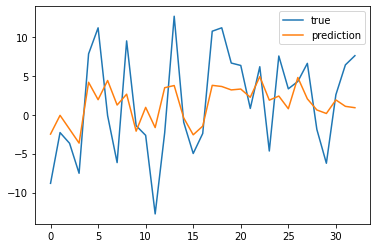

In [1121]:
pyplot.plot(inv_y, label='true')
pyplot.plot(inv_yhat, label='prediction')
pyplot.legend()
pyplot.show()